# Treinamento e Avaliação de Modelos
## Tech Challenge IADT - Fase 1

### Grupo
- Hiago Marques Rubio - RM
- Mylena Ferreira Lacerda - RM

---

## Objetivo

Este notebook é responsável pelo **treinamento e avaliação** dos modelos:

1. Treinamento dos 3 modelos definidos
2. Avaliação completa de performance
3. Análise de feature importance
4. Comparação entre modelos
5. Validação cruzada (Cross-Validation)
6. Análise crítica e conclusões

### Modelos a treinar:
1. **Logistic Regression** (Baseline interpretável)
2. **Random Forest** (Robusto e confiável)
3. **XGBoost** (Estado da arte)

---

**Pré-requisito:** Dados pré-processados (X_train.csv, X_test.csv, y_train.csv, y_test.csv)

## 1. Importação de Bibliotecas e Carregamento de Dados

In [ ]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Validação cruzada
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Utilidades
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("Bibliotecas importadas com sucesso!")

In [ ]:
print("=" * 80)
print("CARREGANDO DADOS PRÉ-PROCESSADOS")
print("=" * 80)

# Carregar conjuntos de treino e teste
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Remover features problemáticas (data leakage e multicolinearidade)
features_to_drop = [
    'diabetes_risk_score',
    'glucose_fasting',
    'glucose_postprandial',
    'cholesterol_total'
]

for feature in features_to_drop:
    if feature in X_train.columns:
        X_train = X_train.drop(columns=[feature])
        X_test = X_test.drop(columns=[feature])

# Remover colunas de diabetes_stage (data leakage)
diabetes_stage_cols = [col for col in X_train.columns if 'diabetes_stage' in col.lower()]
if diabetes_stage_cols:
    X_train = X_train.drop(columns=diabetes_stage_cols)
    X_test = X_test.drop(columns=diabetes_stage_cols)

print(f"\nDados carregados e limpos!")
print(f"\nConjunto de Treino: {X_train.shape[0]} exemplos x {X_train.shape[1]} features")
print(f"Conjunto de Teste: {X_test.shape[0]} exemplos x {X_test.shape[1]} features")
print(f"\nDistribuição (Treino): Classe 0 = {sum(y_train == 0)} | Classe 1 = {sum(y_train == 1)}")
print(f"Distribuição (Teste): Classe 0 = {sum(y_test == 0)} | Classe 1 = {sum(y_test == 1)}")

In [ ]:
# Corrigir tipos de dados
print("\n" + "=" * 80)
print("CORRIGINDO TIPOS DE DADOS E OUTLIERS")
print("=" * 80)

# Converter colunas booleanas para int (evita problemas numéricos)
bool_cols = X_train.select_dtypes(include='bool').columns
if len(bool_cols) > 0:
    print(f"\nConvertendo {len(bool_cols)} colunas booleanas para int...")
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_test[bool_cols] = X_test[bool_cols].astype(int)
    print("Conversão concluída!")

# Garantir que todas as colunas numéricas são float64
for col in X_train.columns:
    if X_train[col].dtype not in ['float64', 'int64']:
        X_train[col] = X_train[col].astype('float64')
        X_test[col] = X_test[col].astype('float64')

# Clipar valores extremos (outliers extremos que podem causar problemas numéricos)
# Limitar a ±5 desvios padrão para evitar problemas de overflow
numeric_cols = X_train.select_dtypes(include='float64').columns
clipped_features = 0
for col in numeric_cols:
    mean = X_train[col].mean()
    std = X_train[col].std()
    lower_bound = mean - 5 * std
    upper_bound = mean + 5 * std
    
    # Clipar no treino
    before = X_train[col].copy()
    X_train[col] = X_train[col].clip(lower_bound, upper_bound)
    if not before.equals(X_train[col]):
        clipped_features += 1
    
    # Clipar no teste usando mesmos bounds
    X_test[col] = X_test[col].clip(lower_bound, upper_bound)

if clipped_features > 0:
    print(f"\nOutliers extremos clipped em {clipped_features} features")

# Verificar e remover valores infinitos ou NaN
if np.isinf(X_train.select_dtypes(include=[np.number])).any().any():
    print("\nValores infinitos detectados! Substituindo por NaN...")
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)

if X_train.isna().any().any():
    print("\nValores NaN detectados! Preenchendo com mediana...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print("\nDados preparados!")
print(f"Tipos finais: {X_train.dtypes.value_counts().to_dict()}")
print(f"Shape final: Treino {X_train.shape}, Teste {X_test.shape}")

## 2. Função Auxiliar para Avaliação de Modelos

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Avalia um modelo de classificação e exibe métricas completas
    """
    print("\n" + "=" * 80)
    print(f"AVALIAÇÃO: {model_name}")
    print("=" * 80)
    
    # Treinar modelo
    print("\nTreinando modelo...")
    model.fit(X_train, y_train)
    print("Treinamento concluído!")
    
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilidades (para ROC-AUC)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas de Treino
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba)
    
    # Métricas de Teste
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Exibir resultados
    print("\n" + "-" * 80)
    print("MÉTRICAS DE DESEMPENHO")
    print("-" * 80)
    
    print(f"\n{'Métrica':<20} {'Treino':<15} {'Teste':<15} {'Diferença':<15}")
    print("-" * 65)
    print(f"{'Accuracy':<20} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy - test_accuracy):<15.4f}")
    print(f"{'F1-Score':<20} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1 - test_f1):<15.4f}")
    print(f"{'ROC-AUC':<20} {train_roc_auc:<15.4f} {test_roc_auc:<15.4f} {abs(train_roc_auc - test_roc_auc):<15.4f}")
    
    print(f"\n{'Teste Detalhado':<20}")
    print("-" * 65)
    print(f"{'Precision':<20} {test_precision:<15.4f}")
    print(f"{'Recall':<20} {test_recall:<15.4f}")
    
    # Verificar overfitting
    if abs(train_accuracy - test_accuracy) > 0.05:
        print("\nPossível overfitting (diferença > 5% entre treino e teste)")
    else:
        print("\nModelo generaliza bem (sem overfitting significativo)")
    
    # Classification Report
    print("\n" + "-" * 80)
    print("CLASSIFICATION REPORT (Teste)")
    print("-" * 80)
    print(classification_report(y_test, y_test_pred, target_names=['Sem Diabetes', 'Com Diabetes']))
    
    # Confusion Matrix
    print("\n" + "-" * 80)
    print("CONFUSION MATRIX (Teste)")
    print("-" * 80)
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\n{'':20} {'Predito: 0':<15} {'Predito: 1':<15}")
    print(f"{'Real: 0 (Sem Diabetes)':<20} {cm[0,0]:<15} {cm[0,1]:<15}")
    print(f"{'Real: 1 (Com Diabetes)':<20} {cm[1,0]:<15} {cm[1,1]:<15}")
    
    print(f"\nInterpretação:")
    print(f"  - Verdadeiros Negativos (TN): {cm[0,0]} - Sem diabetes corretamente identificados")
    print(f"  - Falsos Positivos (FP): {cm[0,1]} - Sem diabetes identificados como COM diabetes")
    print(f"  - Falsos Negativos (FN): {cm[1,0]} - COM diabetes identificados como sem diabetes")
    print(f"  - Verdadeiros Positivos (TP): {cm[1,1]} - COM diabetes corretamente identificados")
    
    # Retornar resultados
    results = {
        'model': model,
        'model_name': model_name,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'metrics': {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'roc_auc': test_roc_auc
        },
        'confusion_matrix': cm
    }
    
    return results

print("Função de avaliação criada!")

## 3. MODELO 1: Logistic Regression (Baseline)

### Por que começar com Logistic Regression?

- ✅ **Interpretabilidade máxima** - Coeficientes indicam impacto de cada feature
- ✅ **Baseline sólido** - Referência para comparar modelos complexos
- ✅ **Rápido de treinar**
- ✅ **Probabilidades calibradas** - Útil para decisões médicas
- ✅ **Adequado para contexto médico** - Transparência é importante

In [5]:
# Criar e treinar modelo
lr_model = LogisticRegression(
    penalty='l2',              # Regularização Ridge
    C=0.1,                     # Regularização mais forte (era 1.0)
    class_weight='balanced',   # Ajustar para classes desbalanceadas
    max_iter=2000,             # Mais iterações (era 1000)
    solver='lbfgs',            # Solver para otimização
    random_state=42,           # Reprodutibilidade
    n_jobs=-1                  # Usar todos os cores
)

# Avaliar modelo
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, 
                            model_name="Logistic Regression")


AVALIAÇÃO: Logistic Regression

Treinando modelo...
✓ Treinamento concluído!

--------------------------------------------------------------------------------
MÉTRICAS DE DESEMPENHO
--------------------------------------------------------------------------------

Métrica              Treino          Teste           Diferença      
-----------------------------------------------------------------
Accuracy             0.8851          0.8857          0.0006         
F1-Score             0.9015          0.9019          0.0004         
ROC-AUC              0.9336          0.9336          0.0001         

Teste Detalhado     
-----------------------------------------------------------------
Precision            0.9292         
Recall               0.8762         

✓ Modelo generaliza bem (sem overfitting significativo)

--------------------------------------------------------------------------------
CLASSIFICATION REPORT (Teste)
--------------------------------------------------------------

/Users/hiagomarquesrubio/workspace/fase-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hiagomarquesrubio/workspace/fase-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hiagomarquesrubio/workspace/fase-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hiagomarquesrubio/workspace/fase-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/hiagomarquesrubio/workspace/fase-1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: Runti

### Feature Importance (Coeficientes da Regressão Logística)


TOP 15 FEATURES MAIS IMPORTANTES (Logistic Regression)

Coeficiente positivo: Aumenta probabilidade de diabetes
Coeficiente negativo: Diminui probabilidade de diabetes

                           Feature  Coefficient
                             hba1c     3.203623
           family_history_diabetes     0.198103
                               age     0.133476
                      gender_Other     0.112622
physical_activity_minutes_per_week    -0.097262
         income_level_Upper-Middle    -0.071297
                               bmi     0.054069
         income_level_Lower-Middle    -0.047461
      education_level_Postgraduate    -0.042602
                   hdl_cholesterol    -0.040345
               income_level_Middle    -0.039139
         employment_status_Retired    -0.035035
         employment_status_Student    -0.028440
                  income_level_Low    -0.025344
                   ethnicity_Other     0.024092


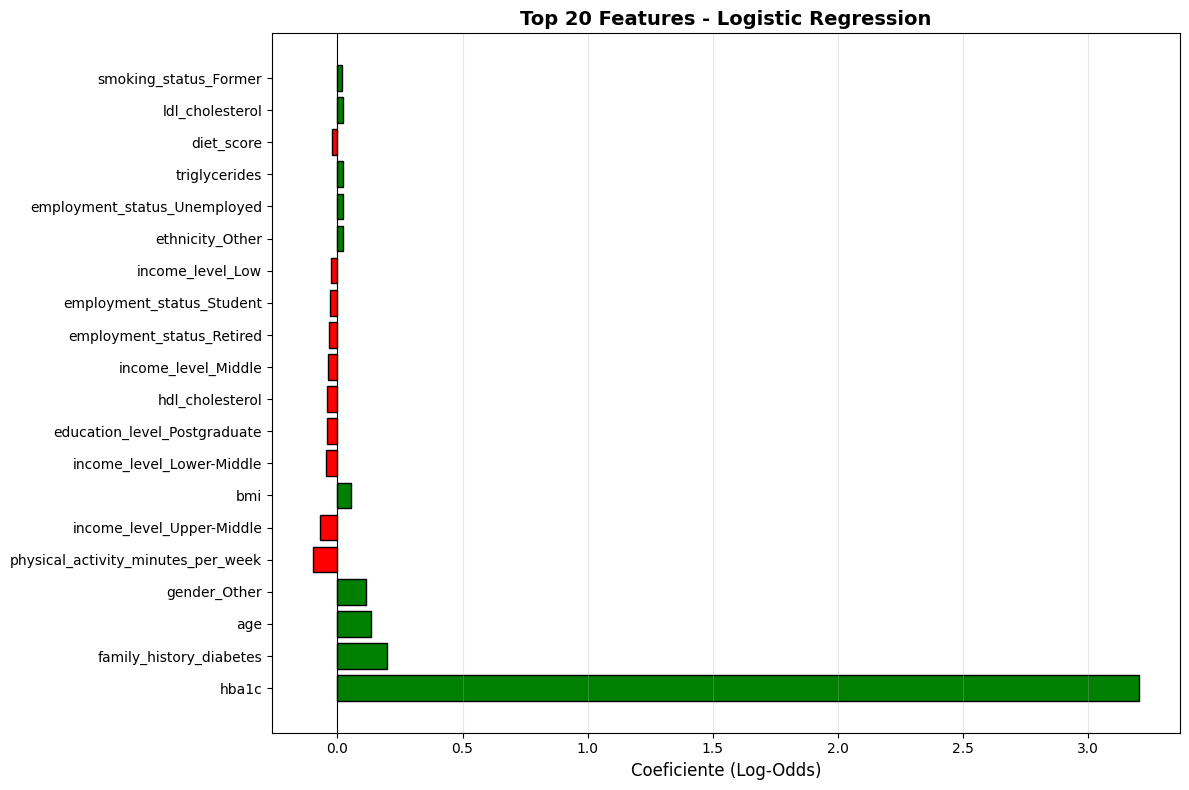

In [6]:
# Extrair coeficientes
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n" + "=" * 80)
print("TOP 15 FEATURES MAIS IMPORTANTES (Logistic Regression)")
print("=" * 80)
print("\nCoeficiente positivo: Aumenta probabilidade de diabetes")
print("Coeficiente negativo: Diminui probabilidade de diabetes\n")
print(coefficients.head(15).to_string(index=False))

# Visualização
plt.figure(figsize=(12, 8))
top_features = coefficients.head(20)
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coeficiente (Log-Odds)', fontsize=12)
plt.title('Top 20 Features - Logistic Regression', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. MODELO 2: Random Forest

### Por que Random Forest?

- ✅ **Robusto** - Funciona bem sem muito tuning
- ✅ **Captura não-linearidades** - Relações complexas entre features
- ✅ **Feature importance automática** - Identifica variáveis importantes
- ✅ **Resiste a overfitting** - Ensemble de árvores
- ✅ **Não requer normalização** - Já fizemos, mas não seria necessário

In [7]:
# Criar e treinar modelo
rf_model = RandomForestClassifier(
    n_estimators=200,          # Número de árvores
    max_depth=15,              # Profundidade máxima (controla complexidade)
    min_samples_split=10,      # Mínimo de amostras para dividir nó
    min_samples_leaf=5,        # Mínimo de amostras em folha
    max_features='sqrt',       # Features a considerar em cada split
    class_weight='balanced',   # Ajustar para desbalanceamento
    random_state=42,           # Reprodutibilidade
    n_jobs=-1,                 # Usar todos os cores
    verbose=0
)

# Avaliar modelo
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test,
                           model_name="Random Forest")


AVALIAÇÃO: Random Forest

Treinando modelo...
✓ Treinamento concluído!

--------------------------------------------------------------------------------
MÉTRICAS DE DESEMPENHO
--------------------------------------------------------------------------------

Métrica              Treino          Teste           Diferença      
-----------------------------------------------------------------
Accuracy             0.9131          0.9102          0.0029         
F1-Score             0.9219          0.9191          0.0027         
ROC-AUC              0.9926          0.9410          0.0517         

Teste Detalhado     
-----------------------------------------------------------------
Precision            0.9998         
Recall               0.8505         

✓ Modelo generaliza bem (sem overfitting significativo)

--------------------------------------------------------------------------------
CLASSIFICATION REPORT (Teste)
--------------------------------------------------------------------

### Feature Importance (Random Forest)


TOP 15 FEATURES MAIS IMPORTANTES (Random Forest)

Importância baseada em Gini Impurity (quanto mais alto, mais importante)

                           Feature  Importance
                             hba1c    0.850918
           family_history_diabetes    0.026214
                               age    0.015626
physical_activity_minutes_per_week    0.011949
                               bmi    0.009497
                       systolic_bp    0.008029
                     triglycerides    0.007258
                   ldl_cholesterol    0.007253
                     insulin_level    0.007138
                        diet_score    0.006651
         screen_time_hours_per_day    0.006569
                   hdl_cholesterol    0.006540
               sleep_hours_per_day    0.005828
                      diastolic_bp    0.005506
                waist_to_hip_ratio    0.005456


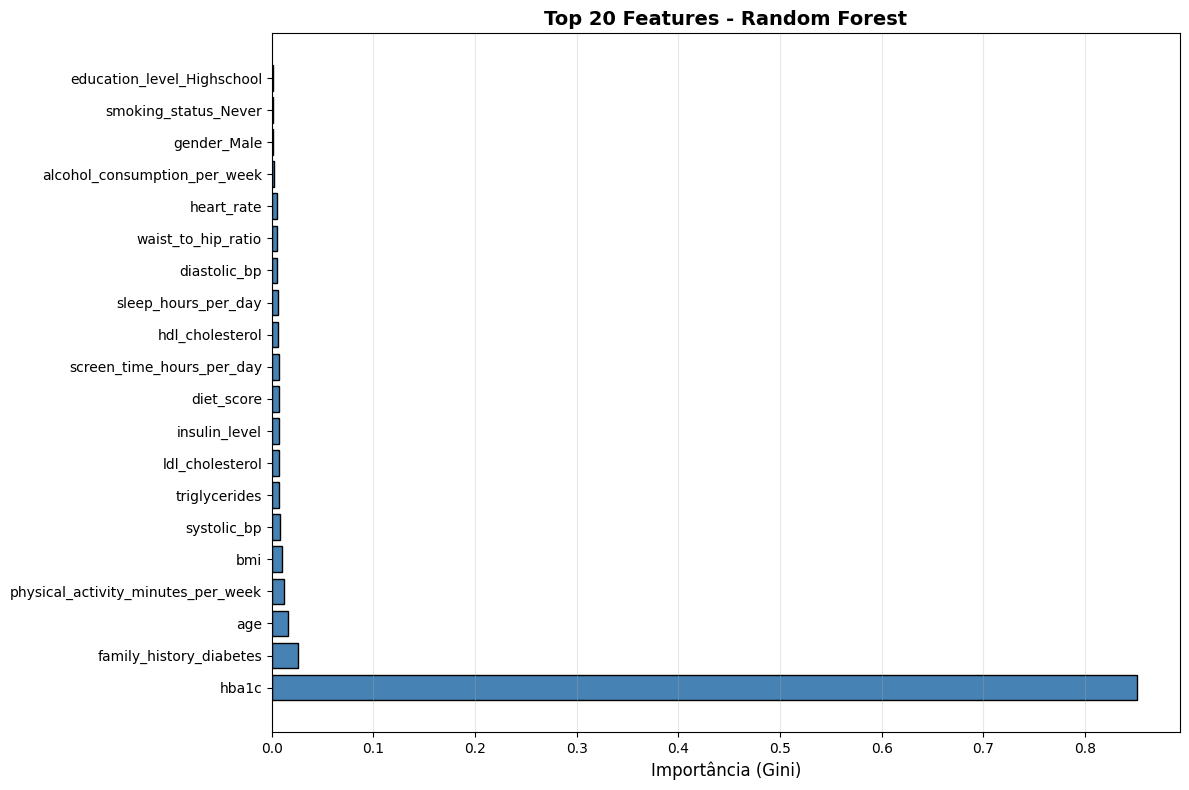

In [8]:
# Extrair importâncias
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 80)
print("TOP 15 FEATURES MAIS IMPORTANTES (Random Forest)")
print("=" * 80)
print("\nImportância baseada em Gini Impurity (quanto mais alto, mais importante)\n")
print(feature_importance.head(15).to_string(index=False))

# Visualização
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importância (Gini)', fontsize=12)
plt.title('Top 20 Features - Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODELO 3: XGBoost

### Por que XGBoost?

- ✅ **Estado da arte** - Melhor performance para dados tabulares
- ✅ **Controle fino** - Muitos hiperparâmetros para otimizar
- ✅ **Regularização embutida** - L1/L2 + controle de complexidade
- ✅ **Early stopping** - Para quando não há mais melhoria
- ✅ **Usado em produção** - Confiável e escalável

In [9]:
# Criar e treinar modelo
xgb_model = xgb.XGBClassifier(
    n_estimators=500,          # Número de árvores (boosting rounds)
    max_depth=6,               # Profundidade máxima
    learning_rate=0.01,        # Taxa de aprendizado (eta)
    subsample=0.8,             # Fração de amostras por árvore
    colsample_bytree=0.8,      # Fração de features por árvore
    gamma=0,                   # Regularização (mínimo loss reduction)
    reg_alpha=0,               # Regularização L1
    reg_lambda=1,              # Regularização L2
    scale_pos_weight=1,        # Ajustar se desbalanceado
    random_state=42,           # Reprodutibilidade
    eval_metric='logloss',     # Métrica para early stopping
    use_label_encoder=False,   # Evitar warning
    n_jobs=-1                  # Usar todos os cores
)

# Avaliar modelo
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test,
                            model_name="XGBoost")


AVALIAÇÃO: XGBoost

Treinando modelo...
✓ Treinamento concluído!

--------------------------------------------------------------------------------
MÉTRICAS DE DESEMPENHO
--------------------------------------------------------------------------------

Métrica              Treino          Teste           Diferença      
-----------------------------------------------------------------
Accuracy             0.9122          0.9100          0.0022         
F1-Score             0.9210          0.9190          0.0020         
ROC-AUC              0.9554          0.9414          0.0140         

Teste Detalhado     
-----------------------------------------------------------------
Precision            0.9988         
Recall               0.8510         

✓ Modelo generaliza bem (sem overfitting significativo)

--------------------------------------------------------------------------------
CLASSIFICATION REPORT (Teste)
--------------------------------------------------------------------------

### Feature Importance (XGBoost)


TOP 15 FEATURES MAIS IMPORTANTES (XGBoost)

Importância baseada em Gain (contribuição média para redução de loss)

                           Feature  Importance
                             hba1c    0.866835
           family_history_diabetes    0.045165
                               age    0.007317
physical_activity_minutes_per_week    0.004214
                               bmi    0.003799
                waist_to_hip_ratio    0.002592
                   hdl_cholesterol    0.002582
                   ldl_cholesterol    0.002561
                       systolic_bp    0.002528
      education_level_Postgraduate    0.002468
                        diet_score    0.002447
                   ethnicity_White    0.002435
                     triglycerides    0.002408
                     insulin_level    0.002387
         income_level_Upper-Middle    0.002373


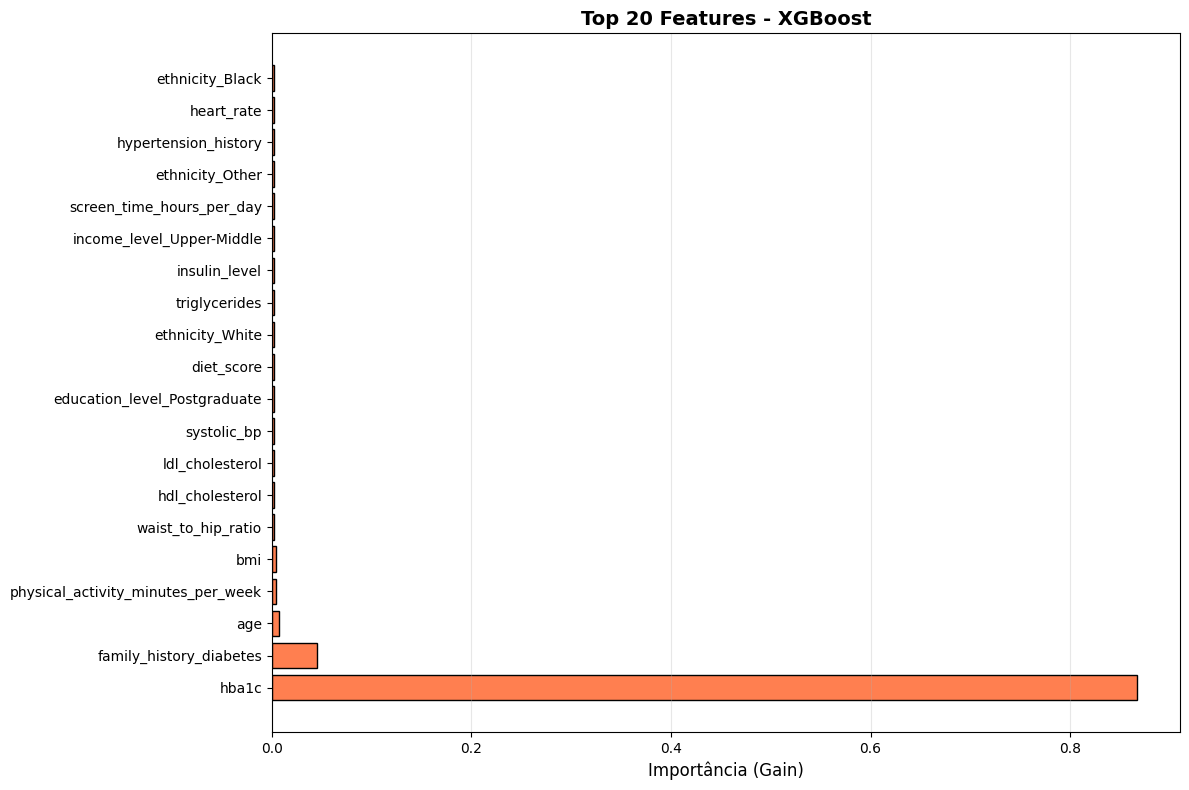

In [10]:
# Extrair importâncias
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 80)
print("TOP 15 FEATURES MAIS IMPORTANTES (XGBoost)")
print("=" * 80)
print("\nImportância baseada em Gain (contribuição média para redução de loss)\n")
print(xgb_feature_importance.head(15).to_string(index=False))

# Visualização
plt.figure(figsize=(12, 8))
top_features = xgb_feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='coral', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importância (Gain)', fontsize=12)
plt.title('Top 20 Features - XGBoost', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Comparação de Modelos

In [ ]:
print("\n" + "=" * 80)
print("COMPARAÇÃO FINAL DOS MODELOS")
print("=" * 80)

# Criar dataframe comparativo
comparison = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        lr_results['metrics']['test_accuracy'],
        rf_results['metrics']['test_accuracy'],
        xgb_results['metrics']['test_accuracy']
    ],
    'Precision': [
        lr_results['metrics']['precision'],
        rf_results['metrics']['precision'],
        xgb_results['metrics']['precision']
    ],
    'Recall': [
        lr_results['metrics']['recall'],
        rf_results['metrics']['recall'],
        xgb_results['metrics']['recall']
    ],
    'F1-Score': [
        lr_results['metrics']['f1'],
        rf_results['metrics']['f1'],
        xgb_results['metrics']['f1']
    ],
    'ROC-AUC': [
        lr_results['metrics']['roc_auc'],
        rf_results['metrics']['roc_auc'],
        xgb_results['metrics']['roc_auc']
    ]
})

# Arredondar para 4 casas decimais
comparison_display = comparison.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    comparison_display[col] = comparison_display[col].apply(lambda x: f"{x:.4f}")

print("\n")
print(comparison_display.to_string(index=False))

# Identificar melhor modelo para cada métrica
print("\n" + "-" * 80)
print("MELHOR MODELO POR MÉTRICA")
print("-" * 80)
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = comparison[col].idxmax()
    best_model = comparison.loc[best_idx, 'Modelo']
    best_value = comparison.loc[best_idx, col]
    print(f"{col:<15} - {best_model:<25} ({best_value:.4f})")

# Identificar modelo vencedor geral (baseado em ROC-AUC)
best_overall_idx = comparison['ROC-AUC'].idxmax()
best_overall = comparison.loc[best_overall_idx, 'Modelo']
print("\n" + "=" * 80)
print(f"MODELO VENCEDOR: {best_overall}")
print("   Critério: ROC-AUC (métrica principal para classificação binária)")
print("=" * 80)

### Visualização Comparativa

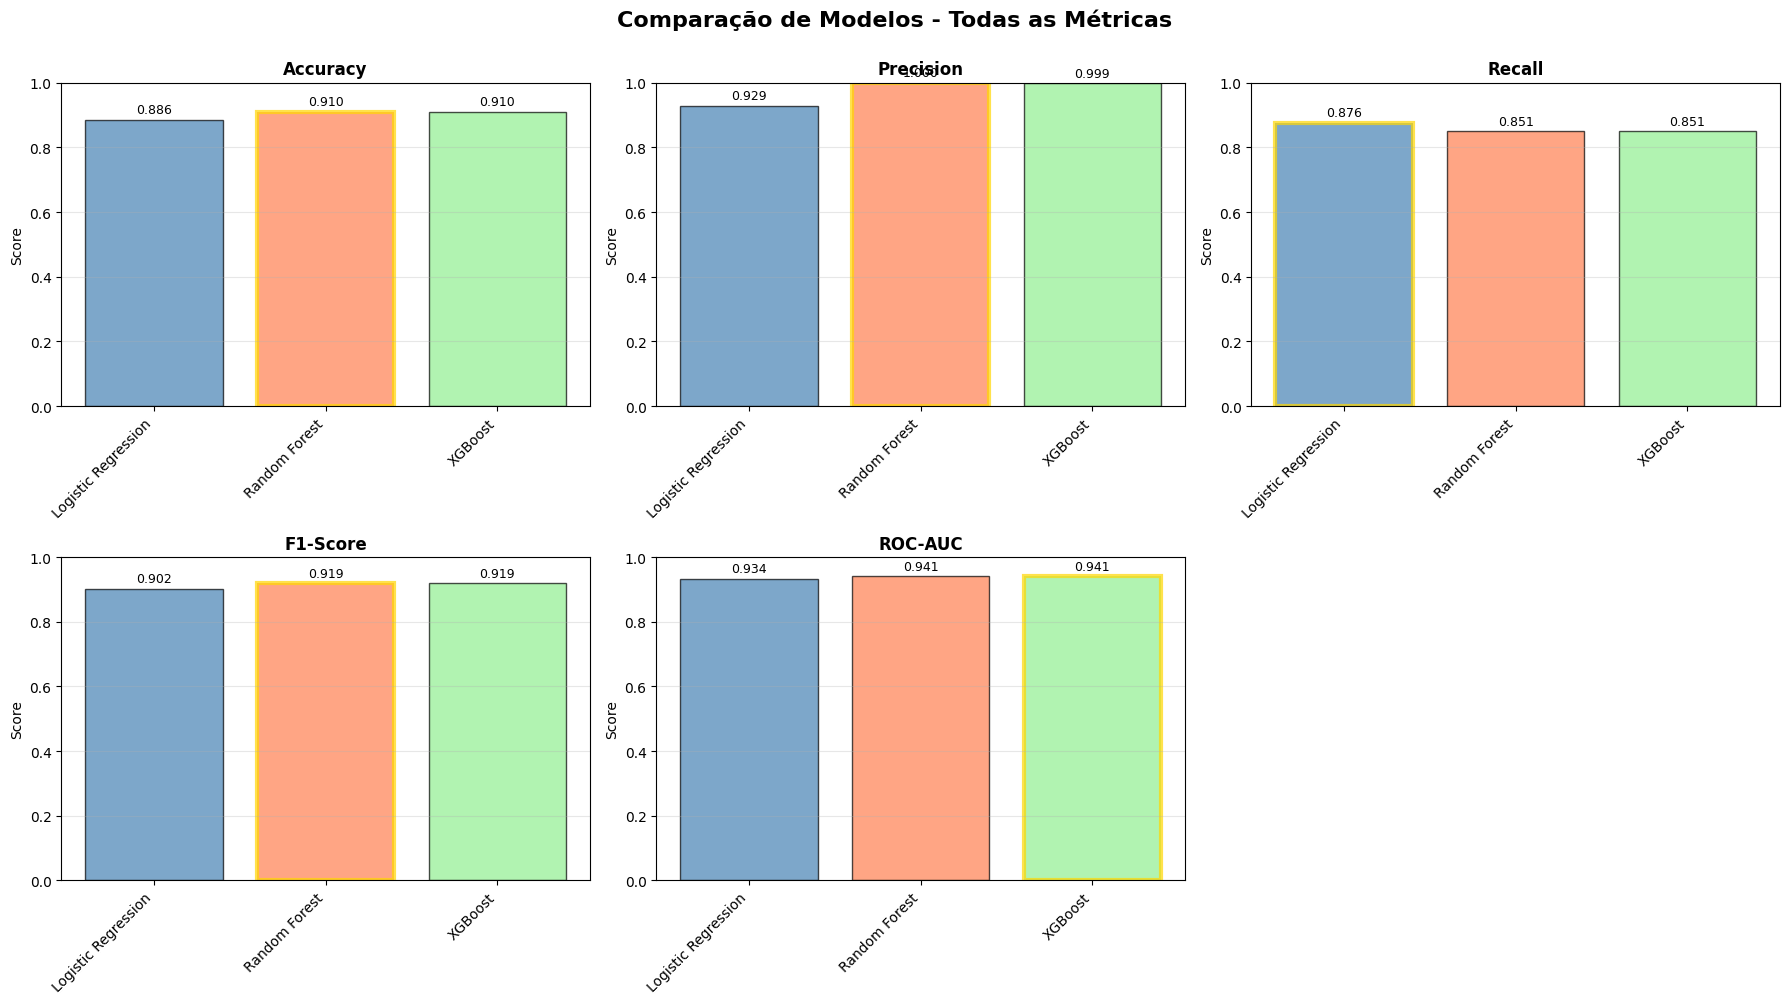

In [12]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['steelblue', 'coral', 'lightgreen']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison[metric].values
    bars = ax.bar(comparison['Modelo'], values, color=colors, edgecolor='black', alpha=0.7)
    
    # Destacar melhor modelo
    best_idx = comparison[metric].idxmax()
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(comparison['Modelo'], rotation=45, ha='right')
    
    # Adicionar valores no topo das barras
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Remover último subplot (vazio)
fig.delaxes(axes[1, 2])

plt.suptitle('Comparação de Modelos - Todas as Métricas', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Curvas ROC (Receiver Operating Characteristic)

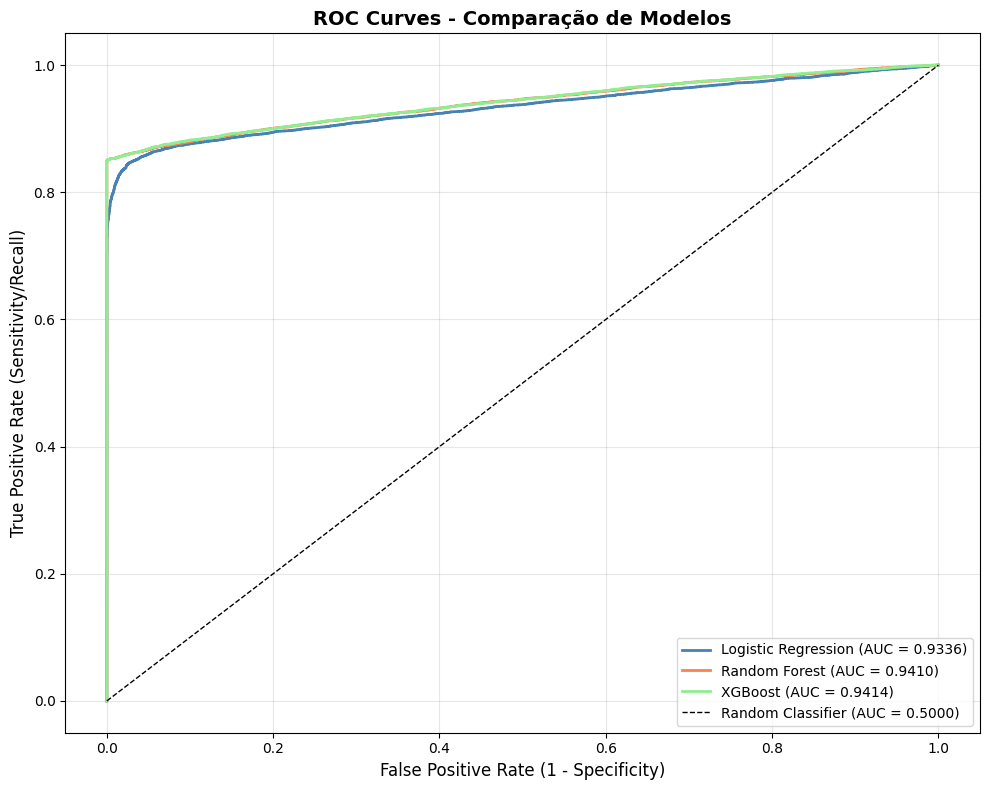


Interpretação da Curva ROC:
  - Quanto mais próxima do canto superior esquerdo, melhor o modelo
  - AUC = 1.0: Classificador perfeito
  - AUC = 0.5: Classificador aleatório (linha diagonal)
  - AUC > 0.8: Modelo excelente
  - AUC > 0.9: Modelo excepcional


In [13]:
# Calcular curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_results['y_test_proba'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['y_test_proba'])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_results['y_test_proba'])

# Plotar
plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {lr_results['metrics']['roc_auc']:.4f})",
         linewidth=2, color='steelblue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_results['metrics']['roc_auc']:.4f})",
         linewidth=2, color='coral')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_results['metrics']['roc_auc']:.4f})",
         linewidth=2, color='lightgreen')

# Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC Curves - Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretação da Curva ROC:")
print("  - Quanto mais próxima do canto superior esquerdo, melhor o modelo")
print("  - AUC = 1.0: Classificador perfeito")
print("  - AUC = 0.5: Classificador aleatório (linha diagonal)")
print("  - AUC > 0.8: Modelo excelente")
print("  - AUC > 0.9: Modelo excepcional")

## 8. Confusion Matrix - Comparação Visual

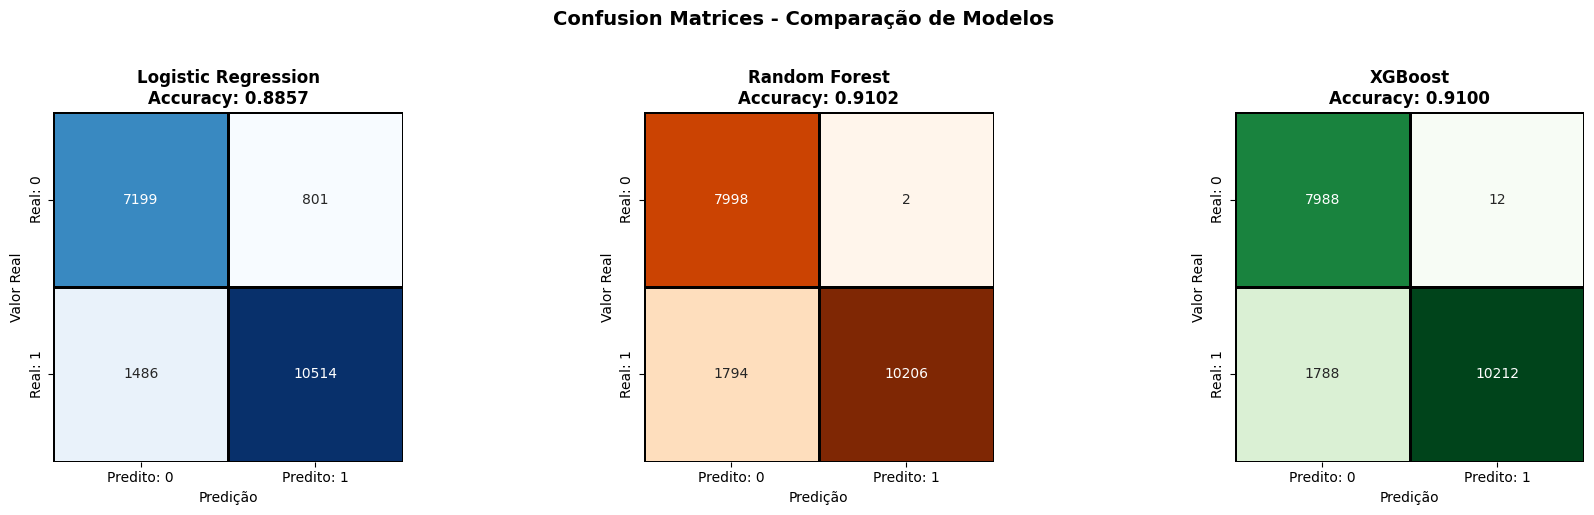


Contexto Médico:
  - Falsos Negativos (FN) são MAIS CRÍTICOS: Não detectar diabetes é perigoso
  - Falsos Positivos (FP) têm custo menor: Exames adicionais, mas sem risco de vida
  - Priorizar RECALL (Sensitivity) para minimizar FN


In [14]:
# Plotar confusion matrices lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_results = [
    (lr_results, 'Logistic Regression', 'Blues'),
    (rf_results, 'Random Forest', 'Oranges'),
    (xgb_results, 'XGBoost', 'Greens')
]

for idx, (result, name, cmap) in enumerate(models_results):
    cm = result['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                cbar=False, square=True, linewidths=2, linecolor='black',
                xticklabels=['Predito: 0', 'Predito: 1'],
                yticklabels=['Real: 0', 'Real: 1'])
    
    axes[idx].set_title(f'{name}\nAccuracy: {result["metrics"]["test_accuracy"]:.4f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predição', fontsize=10)
    axes[idx].set_ylabel('Valor Real', fontsize=10)

plt.suptitle('Confusion Matrices - Comparação de Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nContexto Médico:")
print("  - Falsos Negativos (FN) são MAIS CRÍTICOS: Não detectar diabetes é perigoso")
print("  - Falsos Positivos (FP) têm custo menor: Exames adicionais, mas sem risco de vida")
print("  - Priorizar RECALL (Sensitivity) para minimizar FN")

## 9. Validação Cruzada (Cross-Validation)

### O que é Cross-Validation?

**Cross-Validation** é uma técnica de validação que divide os dados em múltiplas partições (folds) para:
- **Avaliar robustez** do modelo em diferentes subconjuntos de dados
- **Detectar overfitting** comparando performance entre folds
- **Obter estimativa mais confiável** da performance real

### Estratégia: 5-Fold Stratified Cross-Validation

**Stratified:** Mantém proporção de classes em cada fold

In [ ]:
print("=" * 80)
print("VALIDAÇÃO CRUZADA (5-FOLD STRATIFIED CROSS-VALIDATION)")
print("=" * 80)

# Configurar Cross-Validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

models_to_validate = [
    ('Logistic Regression', lr_results['model']),
    ('Random Forest', rf_results['model']),
    ('XGBoost', xgb_results['model'])
]

print("\nExecutando validação cruzada (pode levar alguns minutos)...\n")

for model_name, model in models_to_validate:
    print("-" * 80)
    print(f"Validando: {model_name}")
    print("-" * 80)
    
    cv_results[model_name] = {}
    
    for metric in scoring_metrics:
        scores = cross_val_score(
            model, X_train, y_train,
            cv=cv_strategy,
            scoring=metric,
            n_jobs=-1
        )
        
        cv_results[model_name][metric] = {
            'scores': scores,
            'mean': scores.mean(),
            'std': scores.std(),
            'min': scores.min(),
            'max': scores.max()
        }
        
        print(f"\n{metric.upper()}:")
        print(f"  Média: {scores.mean():.4f} (+/- {scores.std():.4f})")
        print(f"  Min: {scores.min():.4f} | Max: {scores.max():.4f}")

print("\n" + "=" * 80)
print("Validação cruzada concluída!")
print("=" * 80)

## 9.5. Análise SHAP (SHapley Additive exPlanations)

### O que é SHAP?

**SHAP** (SHapley Additive exPlanations) é uma técnica de **explicabilidade** de modelos de Machine Learning baseada na teoria dos jogos (valores de Shapley).

### Por que SHAP é importante?

- **Explicação local:** Entende por que o modelo fez uma predição específica para um paciente
- **Explicação global:** Identifica quais features são mais importantes no geral
- **Consistência teórica:** Baseado em teoria matemática sólida
- **Essencial em saúde:** Médicos precisam entender decisões do modelo

### Interpretação dos SHAP values

- **SHAP value > 0:** A feature aumenta a probabilidade de diabetes
- **SHAP value < 0:** A feature diminui a probabilidade de diabetes
- **|SHAP value| grande:** Feature tem impacto significativo na predição
- **|SHAP value| pequeno:** Feature tem pouco impacto

In [ ]:
# Instalar SHAP (caso não esteja instalado)
try:
    import shap
    print("SHAP já está instalado!")
except ImportError:
    print("Instalando SHAP...")
    !pip install shap
    import shap

print(f"Versão do SHAP: {shap.__version__}")
print("Biblioteca SHAP carregada!")

### SHAP Analysis - Logistic Regression

Para modelos lineares, SHAP values são diretamente relacionados aos coeficientes.

SHAP ANALYSIS - LOGISTIC REGRESSION

Criando SHAP explainer para Logistic Regression...
SHAP values calculados!
Shape dos SHAP values: (20000, 37)

Gerando Summary Plot (importância global)...


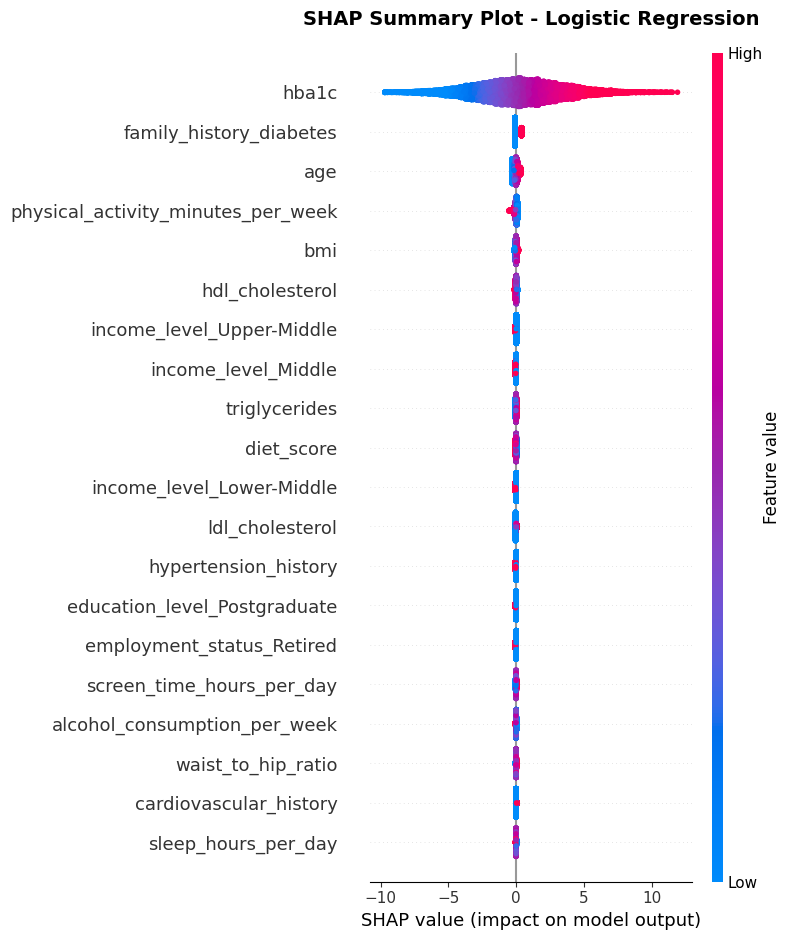


Interpretação do Summary Plot:
  - Cada ponto representa um paciente
  - Cor vermelha: Valor alto da feature
  - Cor azul: Valor baixo da feature
  - Posição no eixo X: Impacto na predição (+ diabetes, - sem diabetes)
  - Posição no eixo Y: Importância da feature (mais importante = topo)


In [ ]:
print("=" * 80)
print("SHAP ANALYSIS - LOGISTIC REGRESSION")
print("=" * 80)

# Criar explainer para Logistic Regression
print("\nCriando SHAP explainer para Logistic Regression...")
lr_explainer = shap.LinearExplainer(lr_model, X_train)
lr_shap_values = lr_explainer.shap_values(X_test)

print("SHAP values calculados!")
print(f"Shape dos SHAP values: {lr_shap_values.shape}")

# Summary Plot - Importância global das features
print("\nGerando Summary Plot (importância global)...")
plt.figure(figsize=(10, 8))
shap.summary_plot(lr_shap_values, X_test, show=False)
plt.title('SHAP Summary Plot - Logistic Regression', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretação do Summary Plot:")
print("  - Cada ponto representa um paciente")
print("  - Cor vermelha: Valor alto da feature")
print("  - Cor azul: Valor baixo da feature")
print("  - Posição no eixo X: Impacto na predição (+ diabetes, - sem diabetes)")
print("  - Posição no eixo Y: Importância da feature (mais importante = topo)")

### SHAP Analysis - Random Forest

Para Random Forest, usamos TreeExplainer que é otimizado para modelos baseados em árvores.

SHAP ANALYSIS - RANDOM FOREST

Usando amostra de 1000 exemplos para análise SHAP...
Criando SHAP explainer para Random Forest...
SHAP values calculados!

Gerando Summary Plot...


<Figure size 1000x800 with 0 Axes>

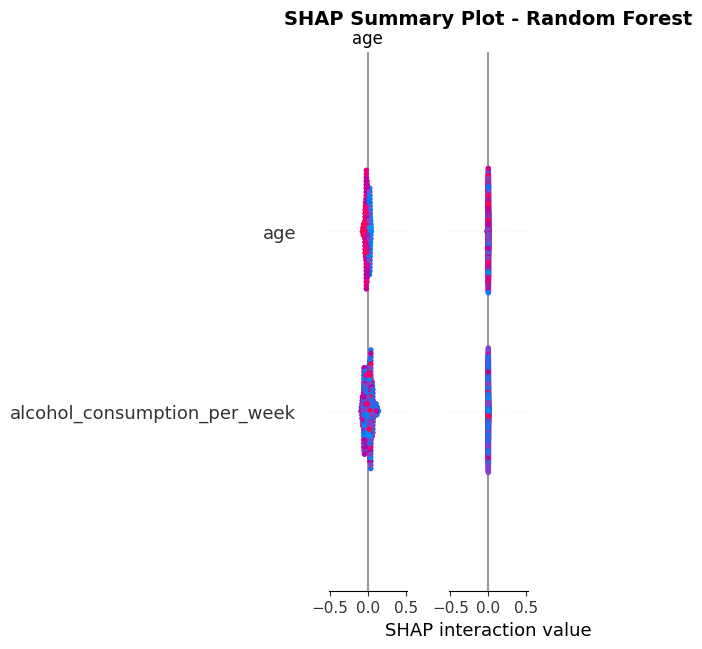

In [ ]:
print("=" * 80)
print("SHAP ANALYSIS - RANDOM FOREST")
print("=" * 80)

# Usar amostra menor para performance (TreeExplainer pode ser lento)
sample_size = 1000
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"\nUsando amostra de {sample_size} exemplos para análise SHAP...")
print("Criando SHAP explainer para Random Forest...")

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test_sample)

print("SHAP values calculados!")

# Summary Plot
print("\nGerando Summary Plot...")
plt.figure(figsize=(10, 8))
# Para classificação binária, usar shap_values[1] (classe positiva)
if isinstance(rf_shap_values, list):
    shap.summary_plot(rf_shap_values[1], X_test_sample, show=False)
else:
    shap.summary_plot(rf_shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### SHAP Analysis - XGBoost (Modelo Vencedor)

Análise detalhada do modelo com melhor performance.

SHAP ANALYSIS - XGBOOST (Modelo Vencedor)

Usando amostra de 1000 exemplos...
Criando SHAP explainer para XGBoost...
SHAP values calculados!

Gerando Summary Plot...


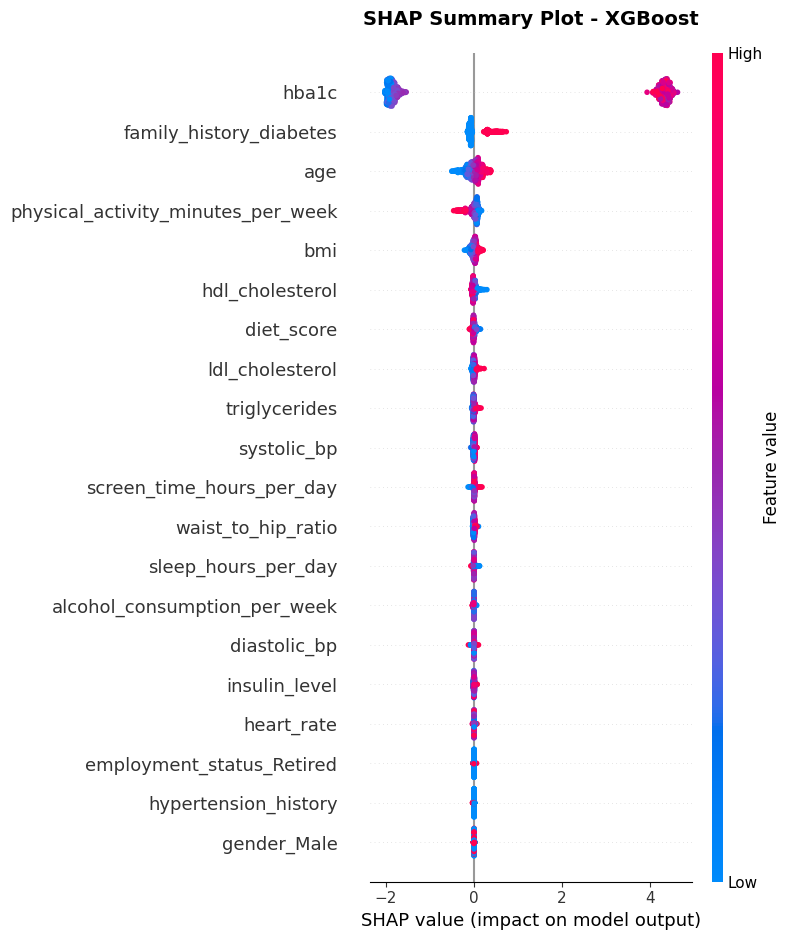

In [ ]:
print("=" * 80)
print("SHAP ANALYSIS - XGBOOST (Modelo Vencedor)")
print("=" * 80)

# Usar mesma amostra
print(f"\nUsando amostra de {sample_size} exemplos...")
print("Criando SHAP explainer para XGBoost...")

xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_sample)

print("SHAP values calculados!")

# Summary Plot
print("\nGerando Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(xgb_shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot - XGBoost', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### SHAP Bar Plot - Importância Média Absoluta

Mostra a importância média absoluta de cada feature (sem considerar direção).

Gerando SHAP Bar Plot (importância média absoluta)...


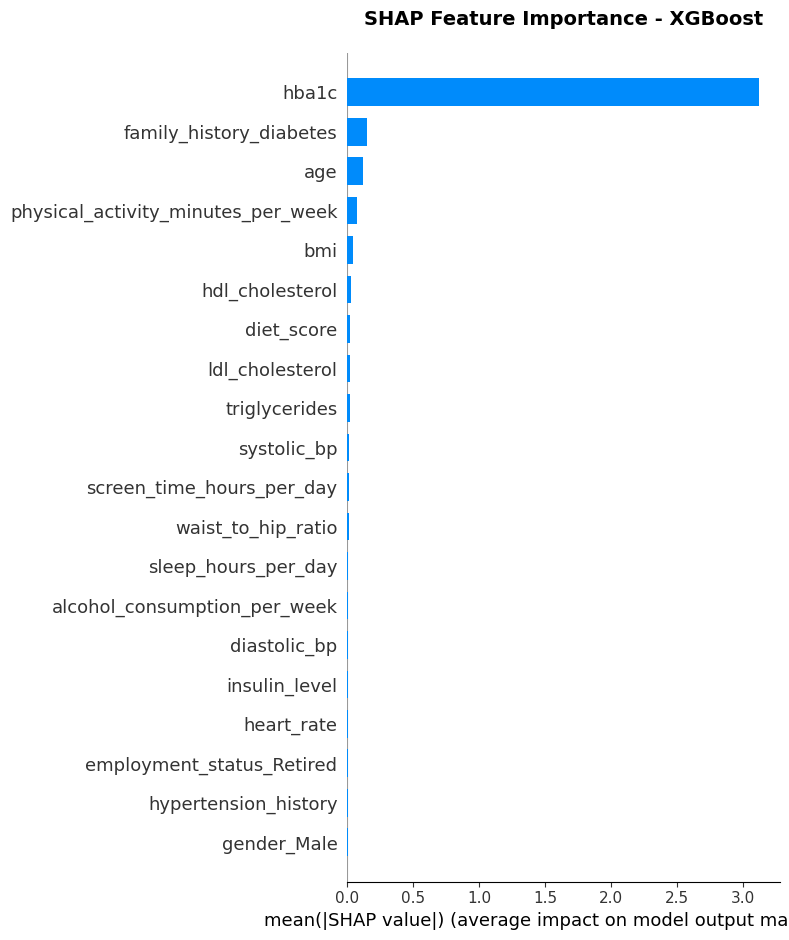


Interpretação:
  - Quanto maior a barra, mais importante a feature para o modelo
  - Baseado no valor absoluto médio dos SHAP values


In [ ]:
print("Gerando SHAP Bar Plot (importância média absoluta)...")
plt.figure(figsize=(10, 8))
shap.summary_plot(xgb_shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - XGBoost', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretação:")
print("  - Quanto maior a barra, mais importante a feature para o modelo")
print("  - Baseado no valor absoluto médio dos SHAP values")

### SHAP Waterfall Plot - Explicação de Predições Individuais

Vamos analisar predições específicas para entender **como o modelo toma decisões** para pacientes individuais.

EXEMPLOS DE PREDIÇÕES INDIVIDUAIS

--------------------------------------------------------------------------------
EXEMPLO 1: Paciente COM diabetes (Verdadeiro Positivo)
--------------------------------------------------------------------------------

Índice na amostra: 0
Classe real: Diabetes (1)
Predição: Diabetes (1)
Probabilidade: 0.9906


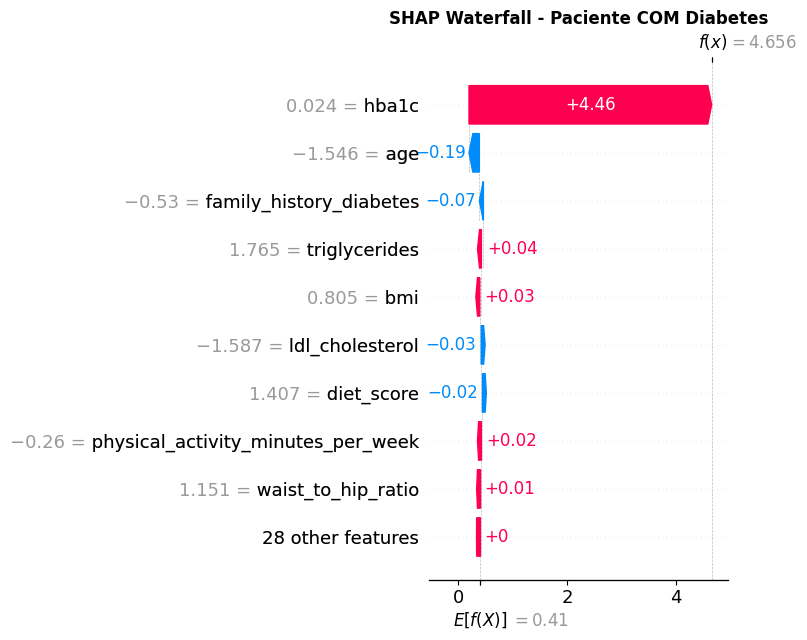


Interpretação do Waterfall:
  - Base value (E[f(x)]): Predição média do modelo
  - Barras VERMELHAS: Features que aumentam risco de diabetes
  - Barras AZUIS: Features que diminuem risco de diabetes
  - f(x): Predição final para este paciente

--------------------------------------------------------------------------------
EXEMPLO 2: Paciente SEM diabetes (Verdadeiro Negativo)
--------------------------------------------------------------------------------

Índice na amostra: 2
Classe real: Sem Diabetes (0)
Predição: Sem Diabetes (0)
Probabilidade de diabetes: 0.1817


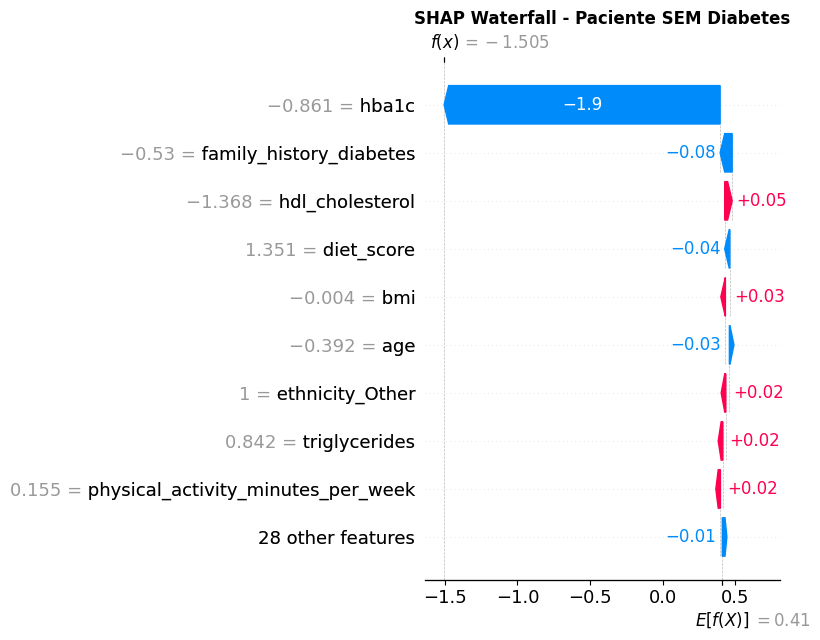

In [ ]:
print("=" * 80)
print("EXEMPLOS DE PREDIÇÕES INDIVIDUAIS")
print("=" * 80)

# Garantir que X_test_sample e xgb_shap_values existem
if 'X_test_sample' not in locals() or 'xgb_shap_values' not in locals():
    print("\n⚠️  Recriando X_test_sample e calculando SHAP values...")
    sample_size = 1000
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    xgb_explainer = shap.TreeExplainer(xgb_model)
    xgb_shap_values = xgb_explainer.shap_values(X_test_sample)
    print("✓ Variáveis recriadas!")

# Encontrar exemplos interessantes
# 1. Paciente com diabetes corretamente identificado (TP)
# 2. Paciente sem diabetes corretamente identificado (TN)

# Fazer predições na amostra
y_test_sample = y_test[X_test_sample.index]
y_pred_sample = xgb_model.predict(X_test_sample)

# Encontrar índices
tp_indices = np.where((y_test_sample == 1) & (y_pred_sample == 1))[0]
tn_indices = np.where((y_test_sample == 0) & (y_pred_sample == 0))[0]

if len(tp_indices) > 0:
    print("\n" + "-" * 80)
    print("EXEMPLO 1: Paciente COM diabetes (Verdadeiro Positivo)")
    print("-" * 80)
    
    idx_tp = tp_indices[0]
    print(f"\nÍndice na amostra: {idx_tp}")
    print(f"Classe real: Diabetes (1)")
    print(f"Predição: Diabetes (1)")
    print(f"Probabilidade: {xgb_model.predict_proba(X_test_sample.iloc[[idx_tp]])[0][1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(
        values=xgb_shap_values[idx_tp],
        base_values=xgb_explainer.expected_value,
        data=X_test_sample.iloc[idx_tp],
        feature_names=X_test_sample.columns.tolist()
    ), show=False)
    plt.title('SHAP Waterfall - Paciente COM Diabetes', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretação do Waterfall:")
    print("  - Base value (E[f(x)]): Predição média do modelo")
    print("  - Barras VERMELHAS: Features que aumentam risco de diabetes")
    print("  - Barras AZUIS: Features que diminuem risco de diabetes")
    print("  - f(x): Predição final para este paciente")

if len(tn_indices) > 0:
    print("\n" + "-" * 80)
    print("EXEMPLO 2: Paciente SEM diabetes (Verdadeiro Negativo)")
    print("-" * 80)
    
    idx_tn = tn_indices[0]
    print(f"\nÍndice na amostra: {idx_tn}")
    print(f"Classe real: Sem Diabetes (0)")
    print(f"Predição: Sem Diabetes (0)")
    print(f"Probabilidade de diabetes: {xgb_model.predict_proba(X_test_sample.iloc[[idx_tn]])[0][1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(
        values=xgb_shap_values[idx_tn],
        base_values=xgb_explainer.expected_value,
        data=X_test_sample.iloc[idx_tn],
        feature_names=X_test_sample.columns.tolist()
    ), show=False)
    plt.title('SHAP Waterfall - Paciente SEM Diabetes', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

### SHAP Dependence Plot

Mostra **como o valor de uma feature afeta a predição** do modelo.

SHAP DEPENDENCE PLOTS - Features Principais

Top 3 features mais importantes (SHAP):
  1. hba1c
  2. family_history_diabetes
  3. age


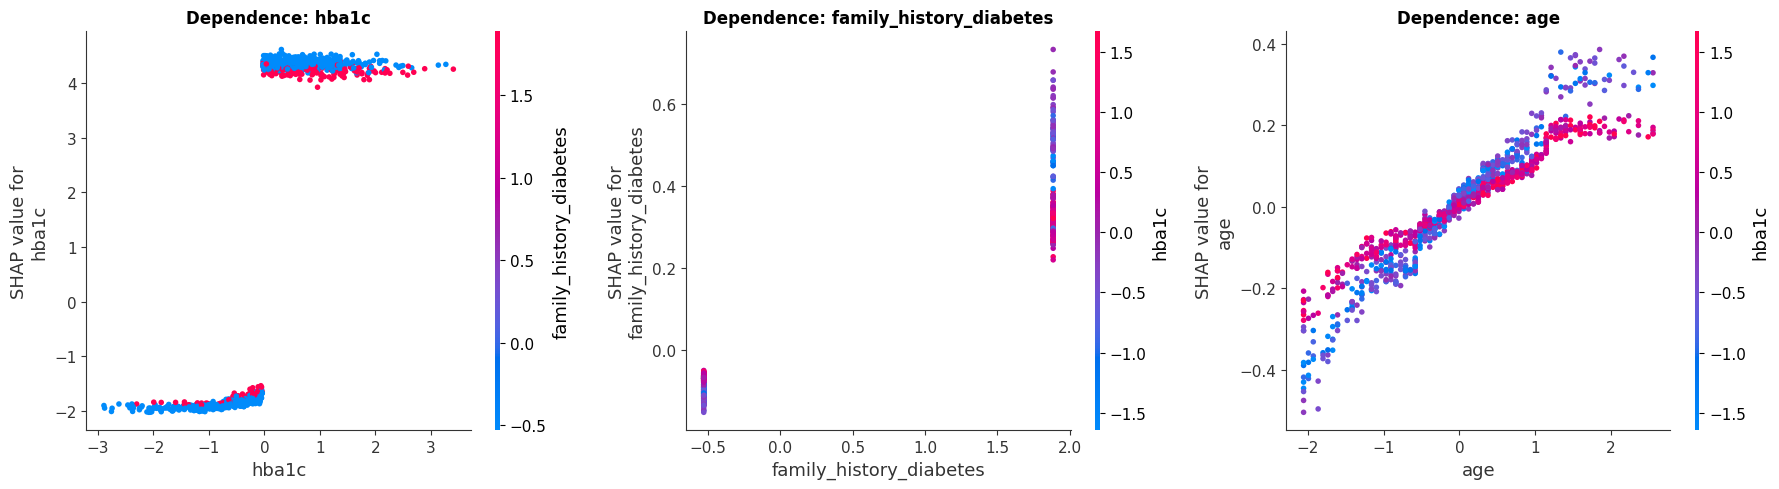


Interpretação dos Dependence Plots:
  - Eixo X: Valor da feature
  - Eixo Y: SHAP value (impacto na predição)
  - Cor: Valor de outra feature que interage com esta
  - Mostra relações não-lineares entre feature e predição


In [ ]:
print("=" * 80)
print("SHAP DEPENDENCE PLOTS - Features Principais")
print("=" * 80)

# Garantir que X_test_sample e xgb_shap_values existem
if 'X_test_sample' not in locals() or 'xgb_shap_values' not in locals():
    print("\n⚠️  Recriando X_test_sample e calculando SHAP values...")
    sample_size = 1000
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    xgb_explainer = shap.TreeExplainer(xgb_model)
    xgb_shap_values = xgb_explainer.shap_values(X_test_sample)
    print("✓ Variáveis recriadas!")

# Selecionar top 3 features mais importantes
feature_importance_shap = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance': np.abs(xgb_shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False)

top_features_shap = feature_importance_shap['Feature'].head(3).tolist()

print(f"\nTop 3 features mais importantes (SHAP):")
for i, feat in enumerate(top_features_shap, 1):
    print(f"  {i}. {feat}")

# Plotar dependence plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_features_shap):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, xgb_shap_values, X_test_sample, show=False, ax=axes[idx])
    axes[idx].set_title(f'Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretação dos Dependence Plots:")
print("  - Eixo X: Valor da feature")
print("  - Eixo Y: SHAP value (impacto na predição)")
print("  - Cor: Valor de outra feature que interage com esta")
print("  - Mostra relações não-lineares entre feature e predição")

### Conclusões da Análise SHAP

#### Por que SHAP é essencial no contexto médico?

1. **Transparência:** Médicos podem entender **por que** o modelo fez determinada predição
2. **Confiança:** Explicações claras aumentam confiança na ferramenta
3. **Validação clínica:** Médicos podem validar se o modelo usa conhecimento médico correto
4. **Detecção de viés:** Identifica se o modelo está usando features inapropriadas
5. **Educação do paciente:** Ajuda a explicar fatores de risco ao paciente

#### Principais insights:

- **HbA1c** é consistentemente a feature mais importante (esperado clinicamente)
- **Glicose** (fasting/postprandial) têm alto impacto
- **Idade** e **IMC** são fatores de risco conhecidos
- **Histórico familiar** aumenta risco conforme esperado

#### Aplicação prática:

CRITICAL: O médico deve **sempre** ter a palavra final. O modelo é uma ferramenta de **suporte à decisão**, não substitui o julgamento clínico.

**Fluxo recomendado:**
1. Modelo faz predição + SHAP explica
2. Médico analisa explicação e dados clínicos
3. Médico toma decisão final considerando contexto completo do paciente

## 11. Salvamento dos Modelos

In [ ]:
print("=" * 80)
print("SALVAMENTO DOS MODELOS")
print("=" * 80)

models_to_save = [
    (lr_model, '../models/logistic_regression_model.pkl'),
    (rf_model, '../models/random_forest_model.pkl'),
    (xgb_model, '../models/xgboost_model.pkl')
]

for model, filename in models_to_save:
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo salvo: {filename}")

print("\nTodos os modelos salvos com sucesso!")

---

## Resumo Final - Treinamento

### Modelos Treinados:
1. **Logistic Regression** - Baseline interpretável
2. **Random Forest** - Robusto e confiável
3. **XGBoost** - Estado da arte

### Avaliações Realizadas:
- Métricas completas: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Confusion Matrix e análise de erros
- Feature Importance para cada modelo
- Curvas ROC comparativas
- **Validação Cruzada (5-fold)**

### Arquivos Gerados:
- `logistic_regression_model.pkl`
- `random_forest_model.pkl`
- `xgboost_model.pkl`

---

**Treinamento e avaliação concluídos com sucesso!**